_Version log: Simulated Annealling._

In [59]:
import sys, time
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [60]:
file_number = 15
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"
training_interferograms, training_uncertainty = cs.open_dataset("1dmockanderrors{:d}".format(file_number), ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

#training_dataset = 3
#training_interferograms, training_uncertainty = cs.open_training_dataset(training_dataset)
#optlocs_file = "data\\training_set{0:d}_optlocs.csv".format(training_dataset)

In [61]:
reduced_points = 10
max_temp = 31
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
min_seperation= 1
iterations= 20000
cooling= 0.998
subsampling_method= "regular"

In [62]:
#########INITAILISATION##########

start_time = time.time()

temps = []
scores = np.array([])
total_points = training_interferograms.shape[-1]
detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method)
initialisation_detectors = np.copy(detectors)
score = new_score = cs.evaluate_score(detectors, training_interferograms, training_uncertainty, regularization_coeffient= regularization_coeffient)
target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########
for n in tqdm(range(iterations)):
    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved
    new_score = cs.evaluate_score(new_detectors, training_interferograms, training_uncertainty, regularization_coeffient)

    if new_score < score:
        detectors = new_detectors
        score = new_score
        improvement = True

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

end_time = time.time()

print(end_time - start_time)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [04:14<00:00, 78.56it/s]

254.59989142417908


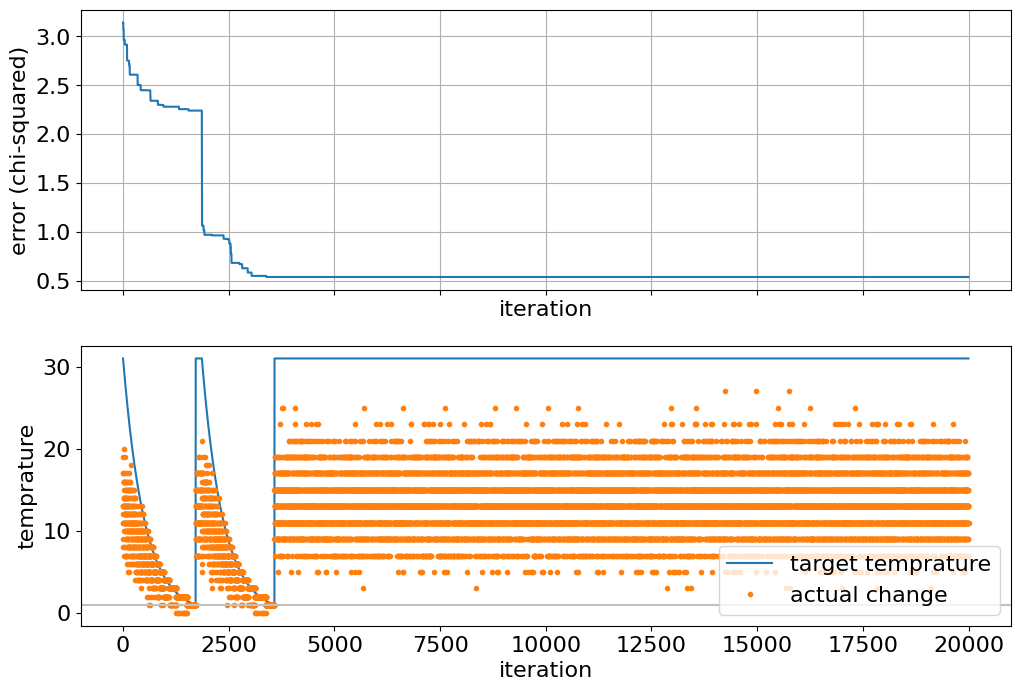

best score = 0.542


In [63]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (chi-squared)", xlabel= "iteration")

axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))

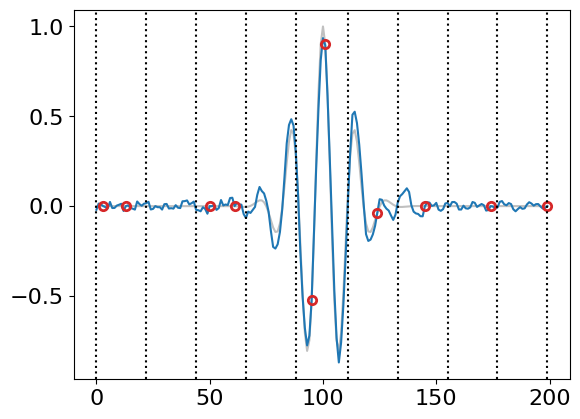

In [64]:
samples = np.full_like(training_interferograms, np.nan)
samples[detectors] = training_interferograms[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)

plt.plot(training_interferograms, color= "silver")
plt.plot(result)
plt.plot(samples, marker= "o", linestyle= "none", markeredgecolor= "tab:red", markerfacecolor= "none", markeredgewidth= 2)
plt.vlines(initialisation_detectors, ymin= 0, ymax= 1, linestyle= ":", color= "k", transform= plt.gca().get_xaxis_transform())
plt.show()

In [65]:
cs.append_array_to_csv(detectors, optlocs_file)

print()
print(*detectors, sep= ",")


3,13,50,61,95,101,124,145,174,199
